#D=8 and D=12 without log scale

D = 8, #sites = 4, GS energy per site = -0.404006, time = 0.00 s
D = 8, #sites = 6, GS energy per site = -0.415596, time = 0.00 s
D = 8, #sites = 8, GS energy per site = -0.421867, time = 0.00 s
D = 8, #sites = 10, GS energy per site = -0.425802, time = 0.01 s
D = 8, #sites = 12, GS energy per site = -0.428505, time = 0.00 s
D = 8, #sites = 14, GS energy per site = -0.430473, time = 0.00 s
D = 8, #sites = 16, GS energy per site = -0.431973, time = 0.01 s
D = 8, #sites = 18, GS energy per site = -0.433151, time = 0.00 s
D = 8, #sites = 20, GS energy per site = -0.434102, time = 0.00 s
D = 8, #sites = 22, GS energy per site = -0.434883, time = 0.00 s
D = 8, #sites = 24, GS energy per site = -0.435540, time = 0.01 s
D = 8, #sites = 26, GS energy per site = -0.436095, time = 0.00 s
D = 8, #sites = 28, GS energy per site = -0.436575, time = 0.00 s
D = 8, #sites = 30, GS energy per site = -0.436989, time = 0.00 s
D = 8, #sites = 32, GS energy per site = -0.437354, time = 0.00 s
D = 8, #sites

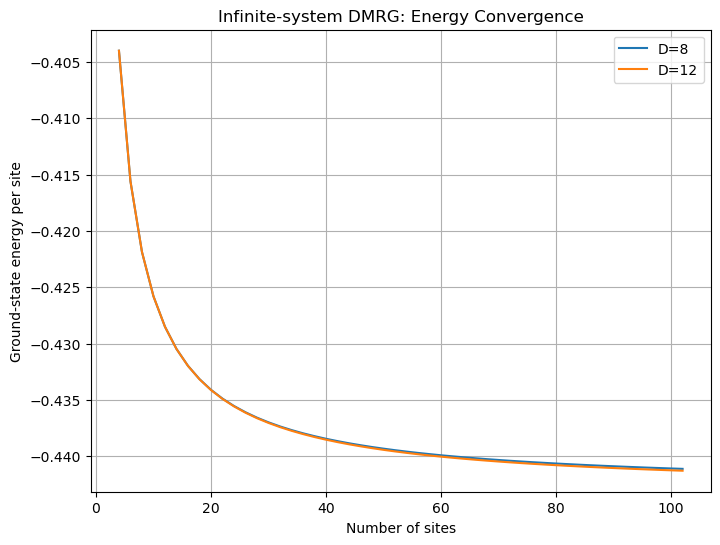

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Define spin operators
Sz = np.array([[0.5,  0], [0, -0.5]])
Sp = np.array([[0, 1], [0, 0]])
Sm = np.array([[0, 0], [1, 0]])
I = np.eye(2)

# Parameters
Nit = 50  # Number of iterations
D_values = [8,12]  # Different bond dimensions
tol_deg = 1e-10  # Tolerance value for eigenvalue cutoff

plt.figure(figsize=(8, 6))

for D in D_values:
    site_list = []
    energy_list = []
    #energy_gap_list = []
    start_time = time.time()
    
    for k in range(1, Nit + 1):
        if k == 1:
            I_S, I_E = I, I
            H_S, H_E = I_S * 0, I_E * 0
            Szborder_S, Spborder_S, Smborder_S = Sz, Sp, Sm
            Szborder_E, Spborder_E, Smborder_E = Sz, Sp, Sm
        else:
            dim_L, dim_R = np.shape(I_L)[0], np.shape(I_R)[0]
            psi_mat = np.reshape(psi, (dim_L, dim_R))
            
            # Left block truncation
            sigma_L = np.matmul(psi_mat, psi_mat.conj().T)
            vals_L, vecs_L = np.linalg.eigh(sigma_L)
            O_L = vecs_L[:, -1].reshape(-1, 1)
            for it in range(1, min(D, len(vals_L))):
                O_L = np.hstack([O_L, vecs_L[:, -1-it].reshape(-1, 1)])
            lines_O_L = np.shape(O_L)[1]
            for it in range(lines_O_L, len(vals_L)):
                if abs(vals_L[-lines_O_L] - vals_L[-1-it]) < tol_deg:
                    O_L = np.hstack([O_L, vecs_L[:, -1-it].reshape(-1, 1)])
                else:
                    break
            
            # Right block truncation
            sigma_R = np.matmul(psi_mat.T, psi_mat.conj())
            vals_R, vecs_R = np.linalg.eigh(sigma_R)
            O_R = vecs_R[:, -1].reshape(-1, 1)
            for it in range(1, min(D, len(vals_R))):
                O_R = np.hstack([O_R, vecs_R[:, -1-it].reshape(-1, 1)])
            lines_O_R = np.shape(O_R)[1]
            for it in range(lines_O_R, len(vals_R)):
                if abs(vals_R[-lines_O_R] - vals_R[-1-it]) < tol_deg:
                    O_R = np.hstack([O_R, vecs_R[:, -1-it].reshape(-1, 1)])
                else:
                    break
            
            # Transform operators
            I_S, H_S = O_L.T @ I_L @ O_L, O_L.T @ H_L @ O_L
            Szborder_S, Spborder_S, Smborder_S = O_L.T @ Szborder_L @ O_L, O_L.T @ Spborder_L @ O_L, O_L.T @ Smborder_L @ O_L
            I_E, H_E = O_R.T @ I_R @ O_R, O_R.T @ H_R @ O_R
            Szborder_E, Spborder_E, Smborder_E = O_R.T @ Szborder_R @ O_R, O_R.T @ Spborder_R @ O_R, O_R.T @ Smborder_R @ O_R
        
        # Extend the blocks
        I_L, H_L = np.kron(I_S, I), np.kron(H_S, I) + np.kron(Szborder_S, Sz) + 0.5 * (np.kron(Spborder_S, Sm) + np.kron(Smborder_S, Sp))
        Szborder_L, Spborder_L, Smborder_L = np.kron(I_S, Sz), np.kron(I_S, Sp), np.kron(I_S, Sm)
        I_R, H_R = np.kron(I, I_E), np.kron(I, H_E) + np.kron(Sz, Szborder_E) + 0.5 * (np.kron(Sp, Smborder_E) + np.kron(Sm, Spborder_E))
        Szborder_R, Spborder_R, Smborder_R = np.kron(Sz, I_E), np.kron(Sp, I_E), np.kron(Sm, I_E)
        
        # Construct the full Hamiltonian
        H_SB = np.kron(H_L, I_R) + np.kron(I_L, H_R) + np.kron(Szborder_L, Szborder_R) + 0.5 * (np.kron(Spborder_L, Smborder_R) + np.kron(Smborder_L, Spborder_R))
        
        # Diagonalization
        En, psin = np.linalg.eigh(H_SB)
        psi = psin[:, 0]
        
        # Store results
        Nsites = 2 + 2 * k
        site_list.append(Nsites)
        energy_list.append(En[0] / Nsites)
        #energy_gap_list.append((En[1] - En[0]) / Nsites)  # Energy gap between ground and first excited state
        print(f'D = {D}, #sites = {Nsites}, GS energy per site = {En[0] / Nsites:.6f}, time = {time.time() - start_time:.2f} s')
        #print(f'D = {D}, #sites = {Nsites}, GS energy per site = {En[0] / Nsites:.6f}, Energy gap = {(En[1] - En[0]) / Nsites:.6f}, time = {time.time() - start_time:.2f} s')
        start_time = time.time()
    
    plt.plot(site_list, energy_list, label=f'D={D}')

# Plot results
plt.xlabel("Number of sites")
plt.ylabel("Ground-state energy per site")
plt.title("Infinite-system DMRG: Energy Convergence")
plt.legend()
plt.grid()
plt.show()


#D=8 and tolerence value=1e-10 

#sites =  4
GS energy per site = 0.40400635094610965
dim of SB =  16
time of iteration (s) =  1.0418894290924072


#sites =  6
GS energy per site = 0.41559618898132106
dim of SB =  64
time of iteration (s) =  0.8033077716827393


#sites =  8
GS energy per site = 0.42186657483598633
dim of SB =  256
time of iteration (s) =  0.45066356658935547


#sites =  10
GS energy per site = 0.4258022489154695
dim of SB =  256
time of iteration (s) =  0.1287679672241211


#sites =  12
GS energy per site = 0.42850477810960874
dim of SB =  256
time of iteration (s) =  0.04852795600891113


#sites =  14
GS energy per site = 0.43047345061433884
dim of SB =  256
time of iteration (s) =  0.023608922958374023


#sites =  16
GS energy per site = 0.4319731747770691
dim of SB =  256
time of iteration (s) =  0.013281583786010742


#sites =  18
GS energy per site = 0.4331506094209854
dim of SB =  256
time of iteration (s) =  0.006565570831298828


#sites =  20
GS energy per site = 0.4341021175176296
dim of SB =

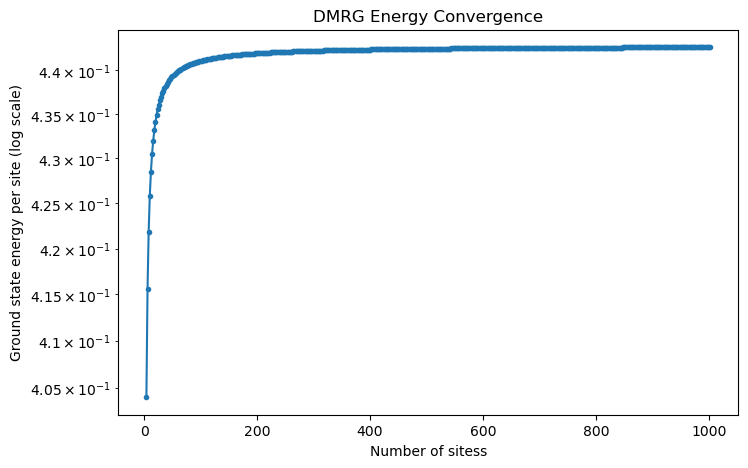

In [8]:
#loading packages
import numpy as np
import time
import matplotlib.pyplot as plt


#introducing the spin system

#S_z=1/2 * (sigma)^z
Sz=np.array([[0.5,  0],
                [0,  -0.5]])

# S^+ = (1/2) * (sigma^x + i sigma^y)
Sp = np.array([[0, 1], 
               [0, 0]])

# S^- = (1/2) * (sigma^x - i sigma^y)
Sm = np.array([[0, 0], 
               [1, 0]])

# Identity matrix I_2
I = np.eye(2)




# parameters
Nit = 500 #no of iterations
D = 8 #bond length 
tol_deg = 1e-10 #setting cutoff 

site_list=[]
energy_list=[]

start_time = time.time()

for k in range (1,Nit+1):
    if k == 1:
        #introducing the left block called it S
        I_S=I
        H_S = I_S * 0
        #this is for when S get l
        Szborder_S=Sz
        Spborder_S=Sp
        Smborder_S=Sm


        #for the right block called it E
        I_E=I
        H_E=I_E*0
        Szborder_E=Sz
        Spborder_E=Sp
        Smborder_E=Sm

        #print(H_E,H_S)






    else:
        dim_L = np.shape(I_L)[0]
        dim_R = np.shape(I_R)[0]
        psi_mat=np.reshape(psi,(dim_L,dim_R))

        #define density matrix operator

        sigma_L=np.matmul(psi_mat,psi_mat.conj().T)     #matrix multiplication $\psi\psidaggar$
        vals_L , vecs_L=np.linalg.eigh(sigma_L)         #diagonalisation

        O_L=np.array(vecs_L[:,-1])          #keep largest number of eigenvalue on left
        for it in range(1,min(D,len(vals_L))):
            O_L = np.vstack([O_L, vecs_L[:,-1-it]]) #add more eigenvalues based on D
        lines_O_L=np.shape(O_L)[0]  # current number of basis states retained/no of states kept

        for it in range(lines_O_L,len(vals_L)):
            if abs(vals_L[-lines_O_L] - vals_L[-1-it]) < tol_deg:
                O_L = np.vstack([O_L, vecs_L[:,-1-it]])
            else:
                break


            # now repeat this steps for right block
        sigma_R = np.matmul(psi_mat.T,psi_mat.conj())
        vals_R,vecs_R = np.linalg.eigh(sigma_R)
        O_R = np.array(vecs_R[:,-1])
        for it in range(1,min(D,len(vals_R))):
            O_R = np.vstack([O_R, vecs_R[:,-1-it]])
       
        lines_O_R = np.shape(O_R)[0]
        for it in range(lines_O_R,len(vals_R)):
            if abs(vals_R[-lines_O_R] - vals_R[-1-it]) < tol_deg:
                O_R = np.vstack([O_R, vecs_R[:,-1-it]])
            else:
                break
            
        #S
        # I_S
        I_S = np.matmul(np.matmul(O_L,I_L),O_L.conj().T)
        # H_S
        H_S = np.matmul(np.matmul(O_L,H_L),O_L.conj().T)
        # relevant operators for S * l
        Szborder_S = np.matmul(np.matmul(O_L,Szborder_L),O_L.conj().T)
        Spborder_S = np.matmul(np.matmul(O_L,Spborder_L),O_L.conj().T)
        Smborder_S = np.matmul(np.matmul(O_L,Smborder_L),O_L.conj().T)

        # E
        # I_E
        I_E = np.matmul(np.matmul(O_R,I_R),O_R.conj().T)
        # H_E
        H_E = np.matmul(np.matmul(O_R,H_R),O_R.conj().T)
        # relevant operators for r * E
        Szborder_E = np.matmul(np.matmul(O_R,Szborder_R),O_R.conj().T)
        Spborder_E = np.matmul(np.matmul(O_R,Spborder_R),O_R.conj().T)
        Smborder_E = np.matmul(np.matmul(O_R,Smborder_R),O_R.conj().T)



    # L = S * l
    # I_L
    I_L = np.kron(I_S,I)
    # H_L
    H_L = np.kron(H_S,I) #H_S * I_l
    #I_S * H_l = 0
    H_L += np.kron(Szborder_S,Sz) + 0.5*( np.kron(Spborder_S,Sm) + np.kron(Smborder_S,Sp)) 
    # relevant operators for L * R
    Szborder_L = np.kron(I_S,Sz)
    Spborder_L = np.kron(I_S,Sp)
    Smborder_L = np.kron(I_S,Sm)
        
    # R = r * E
    # I_R
    I_R = np.kron(I,I_E)
    # H_R
    #H_r * I_E = 0
    H_R = np.kron(I,H_E) #I_r * H_E
    H_R += np.kron(Sz,Szborder_E) + 0.5*( np.kron(Sp,Smborder_E) + np.kron(Sm,Spborder_E)) 
    # relevant operators for L * R
    Szborder_R = np.kron(Sz,I_E)
    Spborder_R = np.kron(Sp,I_E)
    Smborder_R = np.kron(Sm,I_E)
        
    #SB = L * R
    # H_SB
    H_SB = np.kron(H_L,I_R) #H_L * I_R
    H_SB += np.kron(I_L,H_R) #I_L * H_R
    H_SB += np.kron(Szborder_L,Szborder_R) + 0.5*( np.kron(Spborder_L,Smborder_R) + np.kron(Smborder_L,Spborder_R)) 

    # diagonalization
    En,psin = np.linalg.eigh(H_SB)
    # psi for density matrix
    psi = psin[:,0]
       
    # outputs

    Nsites = 2+2*k
    print('#sites = ', Nsites)
    site_list.append(Nsites)
    Egs = abs(En[0])
    print('GS energy per site =', Egs/Nsites)
    energy_list.append(abs(En[0]) / Nsites)
    print('dim of SB = ', np.shape(H_SB)[0])
    print('time of iteration (s) = ', time.time() - start_time)
    start_time = time.time()
    print('\n')

    
plt.figure(figsize=(8, 5))
plt.plot(site_list,energy_list, marker=".")

#plt.xlabel("Number of Sites")
#plt.ylabel("Ground State Energy per Site")
#plt.show()


#plt.xscale('log')  # Logarithmic scale for x-axis
plt.yscale('log')  # Logarithmic scale for y-axis

plt.xlabel('Number of sitess')
plt.ylabel('Ground state energy per site (log scale)')
plt.title('DMRG Energy Convergence')

plt.show()


#For D=8 and D=12 results:

D = 8, #sites = 4, GS energy per site = 0.404006, time = 0.00 s
D = 8, #sites = 6, GS energy per site = 0.415596, time = 0.00 s
D = 8, #sites = 8, GS energy per site = 0.421867, time = 0.00 s
D = 8, #sites = 10, GS energy per site = 0.425802, time = 0.00 s
D = 8, #sites = 12, GS energy per site = 0.428505, time = 0.00 s
D = 8, #sites = 14, GS energy per site = 0.430473, time = 0.00 s
D = 8, #sites = 16, GS energy per site = 0.431973, time = 0.00 s
D = 8, #sites = 18, GS energy per site = 0.433151, time = 0.00 s
D = 8, #sites = 20, GS energy per site = 0.434102, time = 0.00 s
D = 8, #sites = 22, GS energy per site = 0.434883, time = 0.00 s
D = 8, #sites = 24, GS energy per site = 0.435540, time = 0.00 s
D = 8, #sites = 26, GS energy per site = 0.436095, time = 0.00 s
D = 8, #sites = 28, GS energy per site = 0.436575, time = 0.00 s
D = 8, #sites = 30, GS energy per site = 0.436989, time = 0.00 s
D = 8, #sites = 32, GS energy per site = 0.437354, time = 0.00 s
D = 8, #sites = 34, GS energ

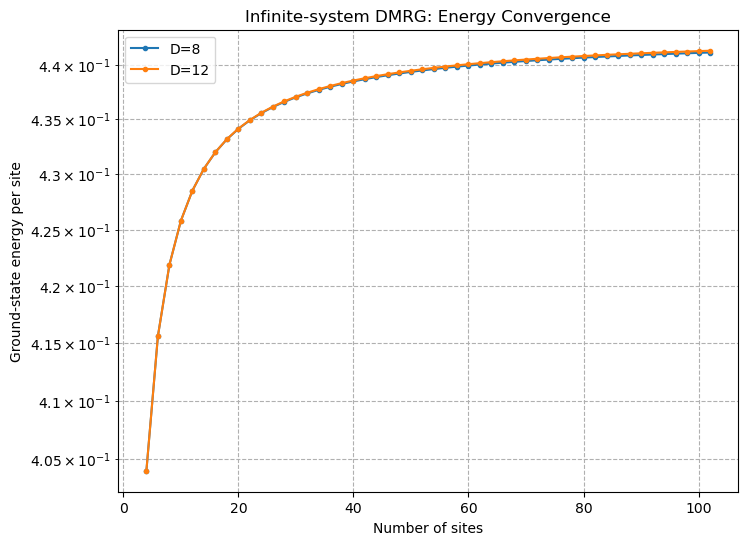

In [25]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Define spin operators
Sz = np.array([[0.5,  0], [0, -0.5]])
Sp = np.array([[0, 1], [0, 0]])
Sm = np.array([[0, 0], [1, 0]])
I = np.eye(2)

# Parameters
Nit = 50  # Number of iterations
D_values = [8, 12]  # Different bond dimensions
tol_deg = 1e-10  # Tolerance value for eigenvalue cutoff

plt.figure(figsize=(8, 6))

for D in D_values:
    site_list = []
    energy_list = []
    start_time = time.time()
    
    for k in range(1, Nit + 1):
        if k == 1:
            I_S, I_E = I, I
            H_S, H_E = I_S * 0, I_E * 0
            Szborder_S, Spborder_S, Smborder_S = Sz, Sp, Sm
            Szborder_E, Spborder_E, Smborder_E = Sz, Sp, Sm
        else:
            dim_L, dim_R = np.shape(I_L)[0], np.shape(I_R)[0]
            psi_mat = np.reshape(psi, (dim_L, dim_R))
            
            # Left block truncation
            sigma_L = np.matmul(psi_mat, psi_mat.conj().T)
            vals_L, vecs_L = np.linalg.eigh(sigma_L)
            O_L = vecs_L[:, -1].reshape(-1, 1)
            for it in range(1, min(D, len(vals_L))):
                O_L = np.hstack([O_L, vecs_L[:, -1-it].reshape(-1, 1)])
            lines_O_L = np.shape(O_L)[1]
            for it in range(lines_O_L, len(vals_L)):
                if abs(vals_L[-lines_O_L] - vals_L[-1-it]) < tol_deg:
                    O_L = np.hstack([O_L, vecs_L[:, -1-it].reshape(-1, 1)])
                else:
                    break
            
            # Right block truncation
            sigma_R = np.matmul(psi_mat.T, psi_mat.conj())
            vals_R, vecs_R = np.linalg.eigh(sigma_R)
            O_R = vecs_R[:, -1].reshape(-1, 1)
            for it in range(1, min(D, len(vals_R))):
                O_R = np.hstack([O_R, vecs_R[:, -1-it].reshape(-1, 1)])
            lines_O_R = np.shape(O_R)[1]
            for it in range(lines_O_R, len(vals_R)):
                if abs(vals_R[-lines_O_R] - vals_R[-1-it]) < tol_deg:
                    O_R = np.hstack([O_R, vecs_R[:, -1-it].reshape(-1, 1)])
                else:
                    break
            
            # Transform operators
            I_S, H_S = O_L.T @ I_L @ O_L, O_L.T @ H_L @ O_L
            Szborder_S, Spborder_S, Smborder_S = O_L.T @ Szborder_L @ O_L, O_L.T @ Spborder_L @ O_L, O_L.T @ Smborder_L @ O_L
            I_E, H_E = O_R.T @ I_R @ O_R, O_R.T @ H_R @ O_R
            Szborder_E, Spborder_E, Smborder_E = O_R.T @ Szborder_R @ O_R, O_R.T @ Spborder_R @ O_R, O_R.T @ Smborder_R @ O_R
        
        # Extend the blocks
        I_L, H_L = np.kron(I_S, I), np.kron(H_S, I) + np.kron(Szborder_S, Sz) + 0.5 * (np.kron(Spborder_S, Sm) + np.kron(Smborder_S, Sp))
        Szborder_L, Spborder_L, Smborder_L = np.kron(I_S, Sz), np.kron(I_S, Sp), np.kron(I_S, Sm)
        I_R, H_R = np.kron(I, I_E), np.kron(I, H_E) + np.kron(Sz, Szborder_E) + 0.5 * (np.kron(Sp, Smborder_E) + np.kron(Sm, Spborder_E))
        Szborder_R, Spborder_R, Smborder_R = np.kron(Sz, I_E), np.kron(Sp, I_E), np.kron(Sm, I_E)
        
        # Construct the full Hamiltonian
        H_SB = np.kron(H_L, I_R) + np.kron(I_L, H_R) + np.kron(Szborder_L, Szborder_R) + 0.5 * (np.kron(Spborder_L, Smborder_R) + np.kron(Smborder_L, Spborder_R))
        
        # Diagonalization
        En, psin = np.linalg.eigh(H_SB)
        psi = psin[:, 0]
        
        # Store results
        Nsites = 2 + 2 * k
        site_list.append(Nsites)
        energy_list.append(abs(En[0]) / Nsites)
        
        print(f'D = {D}, #sites = {Nsites}, GS energy per site = {abs(En[0]) / Nsites:.6f}, time = {time.time() - start_time:.2f} s')
        start_time = time.time()
    
    # Plot energy convergence for this D
    plt.plot(site_list, energy_list, label=f'D={D}', marker='.')

# Plot results
plt.xlabel("Number of sites")
plt.ylabel("Ground-state energy per site")
plt.title("Infinite-system DMRG: Energy Convergence")
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()



#trying to find energy gap

0.6589186225978911
0.4915817769893933
0.39269211092500456
0.3291371508281724
0.28695956195020766
0.2540044774986523
0.23347348346252783
0.21321814772755143
0.20227793814947148
0.18852364950437206
0.18242966331400545
0.17245407038910443
0.16906711882271175
0.16147468485113592
0.15971737624098026
0.1537135464208994
0.15299449778036944
0.14809186517981843
0.14806379018045135
0.1439465013480401
0.14439416387945414
0.14084889233224018
0.1416329465136137
0.13851097090115516
0.13953793009465798
0.1367329916123481
0.1379382773187139
0.13537298952876142
0.13671091237717903
0.1343280668336071
0.13576566394569056
0.13352247071723866
0.1350355803120209
0.13289973900151608
0.13447042177705626
0.13241737421618183
0.13403217271993384
0.13204314178986465
0.1336918770288662
0.131752442382016
0.1334273643567414
0.13152641328728976
0.13322159051164562
0.13135053615108205
0.13306141018324524
0.13121360339786747
0.13293665959001544
0.13110694322080718
0.1328394647663984
0.13102383370193849
0.65891862259789

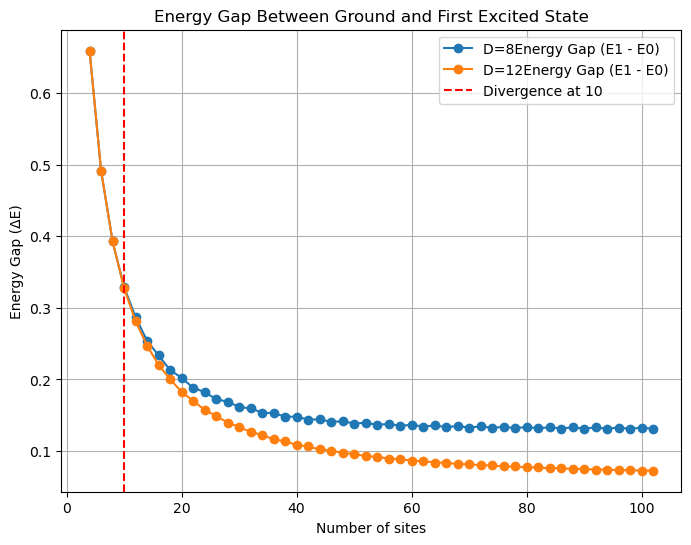

The first significant difference occurs at site = 10


In [15]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Define spin operators
Sz = np.array([[0.5,  0], [0, -0.5]])
Sp = np.array([[0, 1], [0, 0]])
Sm = np.array([[0, 0], [1, 0]])
I = np.eye(2)

# Parameters
Nit = 50  # Number of iterations
D_values = [8, 12]  # Different bond dimensions
tol_deg = 1e-10  # Tolerance value for eigenvalue cutoff
threshold = 1e-3

plt.figure(figsize=(8, 6))

for D in D_values:
    site_list = []
    energy_list = []
    energy_gap_list=[]
    start_time = time.time()
    
    for k in range(1, Nit + 1):
        if k == 1:
            I_S, I_E = I, I
            H_S, H_E = I_S * 0, I_E * 0
            Szborder_S, Spborder_S, Smborder_S = Sz, Sp, Sm
            Szborder_E, Spborder_E, Smborder_E = Sz, Sp, Sm
        else:
            dim_L, dim_R = np.shape(I_L)[0], np.shape(I_R)[0]
            psi_mat = np.reshape(psi, (dim_L, dim_R))
            # Left block truncation
            sigma_L = np.matmul(psi_mat, psi_mat.conj().T)
            vals_L, vecs_L = np.linalg.eigh(sigma_L)
            O_L = vecs_L[:, -1].reshape(-1, 1)
            for it in range(1, min(D, len(vals_L))):
                O_L = np.hstack([O_L, vecs_L[:, -1-it].reshape(-1, 1)])
            lines_O_L = np.shape(O_L)[1]
            for it in range(lines_O_L, len(vals_L)):
                if abs(vals_L[-lines_O_L] - vals_L[-1-it]) < tol_deg:
                    O_L = np.hstack([O_L, vecs_L[:, -1-it].reshape(-1, 1)])
                else:
                    break
            
            # Right block truncation
            sigma_R = np.matmul(psi_mat.T, psi_mat.conj())
            vals_R, vecs_R = np.linalg.eigh(sigma_R)
            O_R = vecs_R[:, -1].reshape(-1, 1)
            for it in range(1, min(D, len(vals_R))):
                O_R = np.hstack([O_R, vecs_R[:, -1-it].reshape(-1, 1)])
            lines_O_R = np.shape(O_R)[1]
            for it in range(lines_O_R, len(vals_R)):
                if abs(vals_R[-lines_O_R] - vals_R[-1-it]) < tol_deg:
                    O_R = np.hstack([O_R, vecs_R[:, -1-it].reshape(-1, 1)])
                else:
                    break
            
            # Transform operators
            I_S, H_S = O_L.T @ I_L @ O_L, O_L.T @ H_L @ O_L
            Szborder_S, Spborder_S, Smborder_S = O_L.T @ Szborder_L @ O_L, O_L.T @ Spborder_L @ O_L, O_L.T @ Smborder_L @ O_L
            I_E, H_E = O_R.T @ I_R @ O_R, O_R.T @ H_R @ O_R
            Szborder_E, Spborder_E, Smborder_E = O_R.T @ Szborder_R @ O_R, O_R.T @ Spborder_R @ O_R, O_R.T @ Smborder_R @ O_R
        
        # Extend the blocks
        I_L, H_L = np.kron(I_S, I), np.kron(H_S, I) + np.kron(Szborder_S, Sz) + 0.5 * (np.kron(Spborder_S, Sm) + np.kron(Smborder_S, Sp))
        Szborder_L, Spborder_L, Smborder_L = np.kron(I_S, Sz), np.kron(I_S, Sp), np.kron(I_S, Sm)
        I_R, H_R = np.kron(I, I_E), np.kron(I, H_E) + np.kron(Sz, Szborder_E) + 0.5 * (np.kron(Sp, Smborder_E) + np.kron(Sm, Spborder_E))
        Szborder_R, Spborder_R, Smborder_R = np.kron(Sz, I_E), np.kron(Sp, I_E), np.kron(Sm, I_E)
        
        # Construct the full Hamiltonian
        H_SB = np.kron(H_L, I_R) + np.kron(I_L, H_R) + np.kron(Szborder_L, Szborder_R) + 0.5 * (np.kron(Spborder_L, Smborder_R) + np.kron(Smborder_L, Spborder_R))
        
        # Diagonalization
        En, psin = np.linalg.eigh(H_SB)
        E0 = En[0]  # Ground state energy
        E1 = En[1]  # First excited state energy
        energy_gap = E1 - E0  # Energy gap
        psi = psin[:, 0]
        
        # Store results
        Nsites = 2 + 2 * k
        site_list.append(Nsites)
        energy_list.append(abs(En[0]) / Nsites)
        energy_gap_list.append(energy_gap)
        print(energy_gap)
        #print(f'D = {D}, #sites = {Nsites}, GS energy per site = {abs(En[0]) / Nsites:.6f}, time = {time.time() - start_time:.2f} s')
        start_time = time.time()
    

    plt.plot(site_list, energy_gap_list, marker='o', label=f'D={D}'"Energy Gap (E1 - E0)")

# Find divergence point
divergence_site = None
for i in range(len(site_lists[8])):
    if abs(energy_gaps[8][i] - energy_gaps[12][i]) > threshold:
        divergence_site = site_lists[8][i]
        break  # Stop at the first occurrence

# Mark the divergence point
if divergence_site:
    plt.axvline(x=divergence_site, color='r', linestyle='--', label=f"Divergence at {divergence_site}")

# Plot settings
plt.xlabel("Number of sites")
plt.ylabel("Energy Gap (ΔE)")
plt.title("Energy Gap Between Ground and First Excited State")
plt.legend()
plt.grid()
plt.show()

print(f"The first significant difference occurs at site = {divergence_site}")




D=8, Sites=4, Energy Gap=0.658919, Entropy=1.337299
D=8, Sites=6, Energy Gap=0.491582, Entropy=0.460751
D=8, Sites=8, Energy Gap=0.392692, Entropy=1.026294
D=8, Sites=10, Energy Gap=0.329137, Entropy=0.659277
D=8, Sites=12, Energy Gap=0.286960, Entropy=1.064263
D=8, Sites=14, Energy Gap=0.254004, Entropy=0.773385
D=8, Sites=16, Energy Gap=0.233473, Entropy=1.097694
D=8, Sites=18, Energy Gap=0.213218, Entropy=0.849824
D=8, Sites=20, Energy Gap=0.202278, Entropy=1.124767
D=8, Sites=22, Energy Gap=0.188524, Entropy=0.904370
D=8, Sites=24, Energy Gap=0.182430, Entropy=1.146122
D=8, Sites=26, Energy Gap=0.172454, Entropy=0.944536
D=8, Sites=28, Energy Gap=0.169067, Entropy=1.162797
D=8, Sites=30, Energy Gap=0.161475, Entropy=0.974647
D=8, Sites=32, Energy Gap=0.159717, Entropy=1.175769
D=8, Sites=34, Energy Gap=0.153714, Entropy=0.997474
D=8, Sites=36, Energy Gap=0.152994, Entropy=1.185845
D=8, Sites=38, Energy Gap=0.148092, Entropy=1.014911
D=8, Sites=40, Energy Gap=0.148064, Entropy=1.193

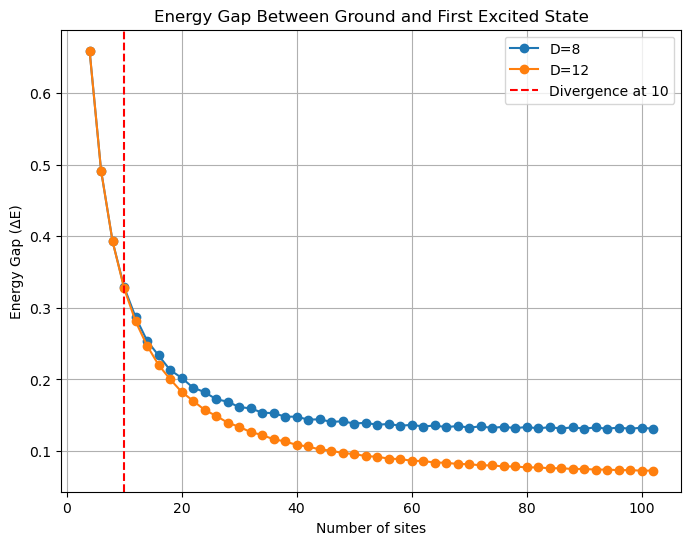

The first significant difference occurs at site = 10


In [30]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Define spin operators
Sz = np.array([[0.5,  0], [0, -0.5]])
Sp = np.array([[0, 1], [0, 0]])
Sm = np.array([[0, 0], [1, 0]])
I = np.eye(2)

# Parameters
Nit = 50  # Number of iterations
D_values = [8, 12]  # Different bond dimensions
tol_deg = 1e-10  # Tolerance for eigenvalue truncation
threshold = 1e-3  # Difference threshold for identifying divergence

# Storage for different D values
energy_gaps = {}
entropies = {}
site_lists = {}

plt.figure(figsize=(8, 6))

for D in D_values:
    site_list = []
    energy_gap_list = []
    entropy_list = []
    
    start_time = time.time()
    
    for k in range(1, Nit + 1):
        if k == 1:
            I_S, I_E = I, I
            H_S, H_E = I_S * 0, I_E * 0
            Szborder_S, Spborder_S, Smborder_S = Sz, Sp, Sm
            Szborder_E, Spborder_E, Smborder_E = Sz, Sp, Sm
        else:
            # Get the current dimensions
            dim_L, dim_R = I_L.shape[0], I_R.shape[0]
            
            # Ensure reshaping works correctly
            psi_size = psi.shape[0]
            if dim_L * dim_R != psi_size:
                dim_L = int(np.sqrt(psi_size))
                dim_R = psi_size // dim_L
            
            psi_mat = np.reshape(psi, (dim_L, dim_R))
            
            # Compute reduced density matrix
            sigma_L = np.matmul(psi_mat, psi_mat.conj().T)
            vals_L, vecs_L = np.linalg.eigh(sigma_L)
            
            # Von Neumann entropy calculation
            valid_vals = vals_L[vals_L > 0]  # Remove zero eigenvalues
            entropy = -np.sum(valid_vals * np.log2(valid_vals)) if len(valid_vals) > 0 else 0
            
            entropy_list.append(entropy)

            # Truncation using eigenvalues
            O_L = vecs_L[:, -1].reshape(-1, 1)
            for it in range(1, min(D, len(vals_L))):
                O_L = np.hstack([O_L, vecs_L[:, -1-it].reshape(-1, 1)])
            lines_O_L = np.shape(O_L)[1]
            for it in range(lines_O_L, len(vals_L)):
                if abs(vals_L[-lines_O_L] - vals_L[-1-it]) < tol_deg:
                    O_L = np.hstack([O_L, vecs_L[:, -1-it].reshape(-1, 1)])
                else:
                    break
            
            # Right block truncation
            sigma_R = np.matmul(psi_mat.T, psi_mat.conj())
            vals_R, vecs_R = np.linalg.eigh(sigma_R)
            O_R = vecs_R[:, -1].reshape(-1, 1)
            for it in range(1, min(D, len(vals_R))):
                O_R = np.hstack([O_R, vecs_R[:, -1-it].reshape(-1, 1)])
            lines_O_R = np.shape(O_R)[1]
            for it in range(lines_O_R, len(vals_R)):
                if abs(vals_R[-lines_O_R] - vals_R[-1-it]) < tol_deg:
                    O_R = np.hstack([O_R, vecs_R[:, -1-it].reshape(-1, 1)])
                else:
                    break
            
            # Transform operators
            I_S, H_S = O_L.T @ I_L @ O_L, O_L.T @ H_L @ O_L
            Szborder_S, Spborder_S, Smborder_S = O_L.T @ Szborder_L @ O_L, O_L.T @ Spborder_L @ O_L, O_L.T @ Smborder_L @ O_L
            I_E, H_E = O_R.T @ I_R @ O_R, O_R.T @ H_R @ O_R
            Szborder_E, Spborder_E, Smborder_E = O_R.T @ Szborder_R @ O_R, O_R.T @ Spborder_R @ O_R, O_R.T @ Smborder_R @ O_R
        
        # Extend the blocks
        I_L, H_L = np.kron(I_S, I), np.kron(H_S, I) + np.kron(Szborder_S, Sz) + 0.5 * (np.kron(Spborder_S, Sm) + np.kron(Smborder_S, Sp))
        Szborder_L, Spborder_L, Smborder_L = np.kron(I_S, Sz), np.kron(I_S, Sp), np.kron(I_S, Sm)
        I_R, H_R = np.kron(I, I_E), np.kron(I, H_E) + np.kron(Sz, Szborder_E) + 0.5 * (np.kron(Sp, Smborder_E) + np.kron(Sm, Spborder_E))
        Szborder_R, Spborder_R, Smborder_R = np.kron(Sz, I_E), np.kron(Sp, I_E), np.kron(Sm, I_E)
        
        # Construct the full Hamiltonian
        H_SB = np.kron(H_L, I_R) + np.kron(I_L, H_R) + np.kron(Szborder_L, Szborder_R) + 0.5 * (np.kron(Spborder_L, Smborder_R) + np.kron(Smborder_L, Spborder_R))
        
        # Diagonalization
        En, psin = np.linalg.eigh(H_SB)
        E0 = En[0]  # Ground state energy
        E1 = En[1]  # First excited state energy
        energy_gap = E1 - E0  # Energy gap
        psi = psin[:, 0]
        
        # Store results
        Nsites = 2 + 2 * k
        site_list.append(Nsites)
        energy_gap_list.append(energy_gap)
        print(f'D={D}, Sites={Nsites}, Energy Gap={energy_gap:.6f}, Entropy={entropy:.6f}')

    energy_gaps[D] = energy_gap_list
    entropies[D] = entropy_list
    site_lists[D] = site_list

    plt.plot(site_list, energy_gap_list, marker='o', label=f'D={D}')

# Find divergence point
divergence_site = None
for i in range(len(site_lists[8])):
    if abs(energy_gaps[8][i] - energy_gaps[12][i]) > threshold:
        divergence_site = site_lists[8][i]
        break  

# Mark the divergence point
if divergence_site:
    plt.axvline(x=divergence_site, color='r', linestyle='--', label=f"Divergence at {divergence_site}")

plt.xlabel("Number of sites")
plt.ylabel("Energy Gap (ΔE)")
plt.title("Energy Gap Between Ground and First Excited State")
plt.legend()
plt.grid()
plt.show()

print(f"The first significant difference occurs at site = {divergence_site}")
